In [4]:
from pathlib import Path

import numpy as np
import torch

from tqdm.auto import tqdm
from tqdm.notebook import tqdm_notebook, trange

import itertools

import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv(), verbose=True)

True

In [5]:
debug = True

# prepare data

In [6]:
from src.config.config import combine_cfgs, get_cfg_defaults
from src.data.datamodule import MyDataModule

In [7]:
# prepare train and validation data
cfg = combine_cfgs('../src/config/experiments/algonauts2021_i3d_flow.yml')
dm = MyDataModule(cfg)
dm.prepare_data()
dm.setup()

fmris_cache_path = Path('/data_smr/huze/.cache/trainval_fmris.pt')

if fmris_cache_path.exists():
    fmris = torch.load(fmris_cache_path)
else:
    fmris = [dm.dataset_train_val.__getitem__(i)[1]
             for i in tqdm(range(dm.dataset_train_val.__len__()))]
    fmris = np.stack(fmris, 0)
    fmris = torch.tensor(fmris)
    torch.save(fmris, fmris_cache_path)

In [8]:
# prepare validation data
cfg = combine_cfgs('../src/config/experiments/algonauts2021_i3d_flow.yml')
dm = MyDataModule(cfg)
dm.prepare_data()
dm.setup()

val_indices = dm.val_dataset.indices

cache_path = Path('/data_smr/huze/.cache/val_fmris.pt')

if cache_path.exists():
    val_fmris = torch.load(cache_path)
else:
    val_fmris = [dm.dataset_train_val.__getitem__(i)[1] for i in tqdm(val_indices)]
    val_fmris = np.stack(val_fmris, 0)
    val_fmris = torch.tensor(val_fmris)
    torch.save(val_fmris, cache_path)

In [9]:
print(fmris.shape, val_fmris.shape)

torch.Size([1000, 161326]) torch.Size([100, 161326])


In [10]:
# load from notebook 301. 302. (cross-notebook-ref)
chaotic_motions = torch.tensor(np.load('./tmp/chaotic_motion.npy'))
# chaotic_motions = chaotic_motions.unsqueeze(0)
face_counts = np.load('./tmp/face_counts.npy')
yes_face_vid_idxs = face_counts.max(-1).nonzero()[0]

In [11]:
from src.utils.analysis import *

In [12]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

# load models

In [11]:
all_df_data = []

In [12]:
# from previous project, notebook 'plot mc fi score, maybe final'
try:
    legacy_run_df = pd.read_csv('./tmp/old_ft_run_df.csv')
    # VGG16 2D + LSTM
    legacy_run_df = legacy_run_df[legacy_run_df.backbone_type == 'bdcn_edge'].sort_values('score', ascending=False)[:]
    legacy_run_df['path'] = legacy_run_df['task_id'].apply(
        lambda task_id: f'/data_smr/huze/projects/my_algonauts/predictions/{task_id}/WB.pt')

    for path in legacy_run_df['path']:
        all_df_data.append({
            'model_sch': 'VGG16 2D + LSTM, multi-layer',
            'path': Path(path),
        })

except FileNotFoundError:
    ...

In [13]:
# from notebook 1. (cross-notebook-ref)

In [14]:
import yaml
from yaml import CLoader
import json
import pandas as pd
from src.config.config import flatten

results_dir = Path('/data/huze/ray_results/algonauts2021')
finished_runs = [path.parent for path in results_dir.glob('**/prediction.npy')]

run_meta_infos = []
for run_dir in tqdm(finished_runs):
    hparams = yaml.load(run_dir.joinpath('hparams.yaml').open(), Loader=CLoader)
    run_meta_info = flatten(hparams)
    run_meta_info['path'] = run_dir

    data = [json.loads(line) for line in run_dir.joinpath('result.json').open()]
    ddf = pd.DataFrame(data)
    run_meta_info['score'] = ddf.val_corr.max()
    run_meta_info['time'] = ddf.time_total_s.max()

    run_meta_infos.append(run_meta_info)

run_df = pd.DataFrame(run_meta_infos)

# fix list unhashable
run_df['MODEL.BACKBONE.LAYERS'] = run_df['MODEL.BACKBONE.LAYERS'].apply(lambda x: tuple(x))
run_df['MODEL.NECK.SPP_LEVELS'] = run_df['MODEL.NECK.SPP_LEVELS'].apply(lambda x: tuple(x))

  0%|          | 0/1496 [00:00<?, ?it/s]

In [15]:
for i_row, row in tqdm(run_df.iterrows()):
    if row['DATASET.ROI'] != 'WB': continue

    model_sch = row['MODEL.BACKBONE.NAME'].upper().replace('_', ' ').replace('I3D', 'Inflated 3D Resnet')
    model_sch += ', '
    model_sch += 'multi-layer' if len(row['MODEL.BACKBONE.LAYERS']) > 1 else 'single-layer'

    all_df_data.append({
        'model_sch': model_sch,
        'path': row.path.joinpath(Path('prediction.npy')),
    })

0it [00:00, ?it/s]

In [16]:
predictions_dict = {
    # from previous project, notebook 'plot mc fi score, maybe final'
    'Baseline,VGG16 2D + LSTM': Path(
        '/data_smr/huze/projects/my_algonauts/predictions/bc4bd42bc70d409daebe27f2c0fae255/WB.pt'),
    # from notebook 1.
    'Baseline,Inflated 3D Resnet FLOW': Path(
        "/data/huze/ray_results/algonauts2021/algonauts2021_i3d_flow-single_layer/run_single_tune_config_135f2_00396_396_DATASET.ROI=WB,MODEL.BACKBONE.LAYERS=_'x3',_,MODEL.BACKBONE.LAYER_PATHWAYS=none,MODEL.NECK._2022-02-25_09-51-08/prediction.npy"),
    # from notebook 1.
    'Baseline,Inflated 3D Resnet RGB': Path(
        "/data/huze/ray_results/algonauts2021/algonauts2021_i3d_rgb-multi_layer/run_single_tune_config_575a8_00066_66_DATASET.ROI=WB,MODEL.BACKBONE.LAYERS=_'x1', 'x2', 'x3', 'x4'_,MODEL.BACKBONE.LAYER_PATHWAYS=_2022-02-26_14-18-59/prediction.npy"),
    # from notebook 900.
    'Best': Path(
        '/data/huze/ray_results/algonauts2021/ensemble_outputs/he_sch=H3,model_sch=single_layer&i3d_rgb+i3d_flow,roi_sch=ROIxSMC,cross_roi_sch=croi_ensemble-prediction.pt'),
}

# from notebook 900. submission output
# submission_scores = [0.2318629775, 0.3216765311, 0.3823963473]
# submission_score_dict = {k: v for k, v in zip(list(predictions_dict.keys()), submission_scores)}
predictions_dict = {k: path for k, path in predictions_dict.items() if path.exists()}
assert len(predictions_dict) > 1

for k, v in predictions_dict.items():
    all_df_data.append({
        'model_sch': k,
        'path': v,
    })

In [17]:
all_df = pd.DataFrame(all_df_data)

In [18]:
print(all_df.model_sch.unique())
print(len(all_df))

['VGG16 2D + LSTM, multi-layer' 'Inflated 3D Resnet RGB, single-layer'
 'Inflated 3D Resnet FLOW, single-layer'
 'Inflated 3D Resnet RGB, multi-layer'
 'Inflated 3D Resnet FLOW, multi-layer' 'Baseline,VGG16 2D + LSTM'
 'Baseline,Inflated 3D Resnet FLOW' 'Baseline,Inflated 3D Resnet RGB'
 'Best']
142


# compute

In [19]:
# on validation set, but internal variance on the whole set

In [35]:
from src.utils.metrics import vectorized_correlation

In [36]:
device = 7

In [37]:
chaotic_motions = chaotic_motions.to(device)
fmris = fmris.to(device)
val_fmris = val_fmris.to(device)

In [24]:
num_fmris = dm.dataset_train_val.__len__()

gt_fmris = fmris
gt_motion_correlation = get_motion_correlation(chaotic_motions[val_indices], gt_fmris[val_indices])
gt_face_index = get_face_index(val_indices, gt_fmris, yes_face_vid_idxs)
gt_r1 = upper_tri_masking(my_corrcoef(val_fmris))

gt_motion_correlation_internal_variance = get_sequential_internal_variance_motion_correlation(
    chaotic_motions, gt_fmris).mean()
gt_face_index_internal_variance = get_sequential_internal_variance_face_index(
    gt_fmris, yes_face_vid_idxs).mean()

In [39]:
res_dicts = []
for i_row, row in tqdm(all_df.iterrows(), total=len(all_df)):
    path = row.path
    if path.name.endswith('.pt'):
        prediction = torch.load(path).float()
    else:
        prediction = torch.tensor(np.load(path)).float()

    prediction = prediction.to(device)

    prediction = prediction[:num_fmris]
    motion_correlation = get_motion_correlation(chaotic_motions[val_indices], prediction[val_indices])
    face_index = get_face_index(val_indices, prediction, yes_face_vid_idxs)

    # part 0 - validation score
    val_score = vectorized_correlation(prediction[val_indices], val_fmris).mean().cpu().item()

    # part 1 - mc/fi score
    motion_correlation_score = np.corrcoef(motion_correlation, gt_motion_correlation)[0, 1]
    face_index_score = np.corrcoef(face_index, gt_face_index)[0, 1]
    # print(motion_correlation_score, face_index_score)

    # part 2 - mf/fi variance
    motion_correlation_internal_variance = get_sequential_internal_variance_motion_correlation(
        chaotic_motions, prediction).mean()
    face_index_internal_variance = get_sequential_internal_variance_face_index(
        prediction, yes_face_vid_idxs).mean()
    # print(motion_correlation_internal_variance, face_index_internal_variance)

    # part 3 - rsa score
    r1 = upper_tri_masking(my_corrcoef(prediction[val_indices]))
    rsa_score = my_corrcoef(torch.stack([r1, gt_r1]))[0, 1].cpu().item()
    # print(rsa_score)

    res_dicts.append({
        'val_score': val_score,
        'rsa_score': rsa_score,
        'motion_correlation_internal_variance': motion_correlation_internal_variance,
        'face_index_internal_variance': face_index_internal_variance,
        'motion_correlation_score': motion_correlation_score,
        'face_index_score': face_index_score,
    })

  0%|          | 0/142 [00:00<?, ?it/s]

In [40]:
res_df = pd.DataFrame(res_dicts)

In [21]:
res_df = all_df.join(res_df)

In [22]:
res_df.to_csv('./tmp/scatter_res_df.csv')

In [14]:
res_df = pd.read_csv('./tmp/scatter_res_df.csv')

In [15]:
res_df

,Unnamed: 0.1,model_sch,path,Unnamed: 0,val_score,rsa_score,motion_correlation_internal_variance,face_index_internal_variance,motion_correlation_score,face_index_score
0,0,"VGG16 2D + LSTM, multi-layer",/data_smr/huze/projects/my_algonauts/predictio...,0,0.098714,0.165938,0.121158,0.061067,-0.000706,0.209236
1,1,"VGG16 2D + LSTM, multi-layer",/data_smr/huze/projects/my_algonauts/predictio...,1,0.096834,0.187050,0.113469,0.064523,0.040895,0.169601
2,2,"VGG16 2D + LSTM, multi-layer",/data_smr/huze/projects/my_algonauts/predictio...,2,0.095441,0.180433,0.108145,0.061399,0.086124,0.211590
3,3,"VGG16 2D + LSTM, multi-layer",/data_smr/huze/projects/my_algonauts/predictio...,3,0.093370,0.208989,0.109973,0.054793,0.039904,0.166535
4,4,"VGG16 2D + LSTM, multi-layer",/data_smr/huze/projects/my_algonauts/predictio...,4,0.093215,0.178489,0.107435,0.057659,-0.030841,0.205971
...,...,...,...,...,...,...,...,...,...,...
137,137,"Inflated 3D Resnet FLOW, multi-layer",/data/huze/ray_results/algonauts2021/algonauts...,137,0.120473,0.355977,0.100825,0.054965,0.244164,0.104441
138,138,"Baseline,VGG16 2D + LSTM",/data_smr/huze/projects/my_algonauts/predictio...,138,0.098714,0.165938,0.121158,0.061067,-0.000706,0.209236
139,139,"Baseline,Inflated 3D Resnet FLOW",/data/huze/ray_results/algonauts2021/algonauts...,139,0.129725,0.339108,0.088547,0.057060,0.279435,0.132423
140,140,"Baseline,Inflated 3D Resnet RGB",/data/huze/ray_results/algonauts2021/algonauts...,140,0.147791,0.403581,0.095127,0.050209,0.276001,0.207912


In [25]:
num_fmris = dm.dataset_train_val.__len__()

gt_fmris = fmris
gt_motion_correlation = get_motion_correlation(chaotic_motions[val_indices], gt_fmris[val_indices])
gt_face_index = get_face_index(val_indices, gt_fmris, yes_face_vid_idxs)
gt_r1 = upper_tri_masking(my_corrcoef(val_fmris))

gt_motion_correlation_internal_variance = get_sequential_internal_variance_motion_correlation(
    chaotic_motions, gt_fmris).mean()
gt_face_index_internal_variance = get_sequential_internal_variance_face_index(
    gt_fmris, yes_face_vid_idxs).mean()

# nice scatter plot

In [26]:
x_key = 'val_score'
y_keys = ['rsa_score', 'motion_correlation_internal_variance',
       'face_index_internal_variance', 'motion_correlation_score',
       'face_index_score']
labels = res_df['model_sch'].values

In [27]:
def bigger_points(x):
    if 'Baseline' in x:
        return 30
    elif 'Best' in x:
        return 50
    # elif 'multi-layer' in x:
    #     return 5
    else:
        return 1

In [28]:
res_df['size'] = res_df['model_sch'].apply(bigger_points)

In [29]:
def alpha_points(x):
    if 'Baseline' in x:
        return 1.
    elif 'Best' in x:
        return 1.
    elif 'multi-layer' in x:
        return 0.8
    else:
        return 0.5

In [30]:
res_df['alpha'] = res_df['model_sch'].apply(alpha_points)

In [53]:
r_palette_group = {
    'deeppink': ['Inflated 3D Resnet RGB, single-layer', 'Inflated 3D Resnet RGB, multi-layer'],
    'green': ['Inflated 3D Resnet FLOW, single-layer', 'Inflated 3D Resnet FLOW, multi-layer'],
    'deepskyblue': ['VGG16 2D + LSTM, multi-layer'],
}

In [58]:
from matplotlib.font_manager import FontProperties
import matplotlib

# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"

font = FontProperties()
# font.set_family('serif')
# font.set_name('Times New Roman')
font.set_style('italic')

In [59]:
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"

In [60]:
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"

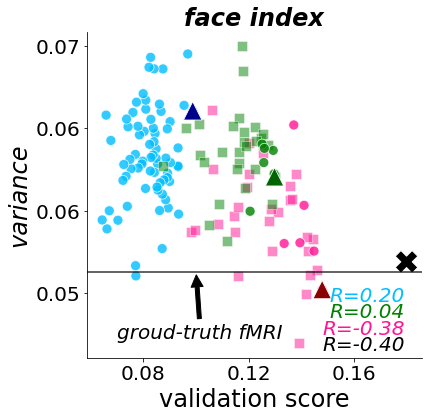

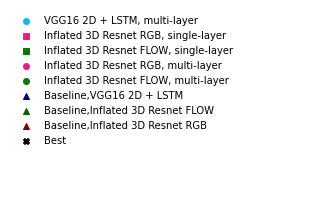

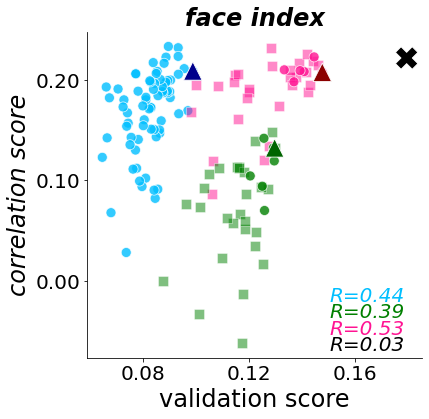

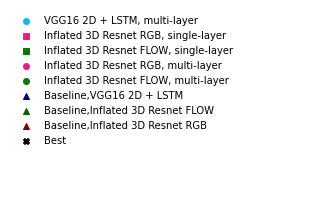

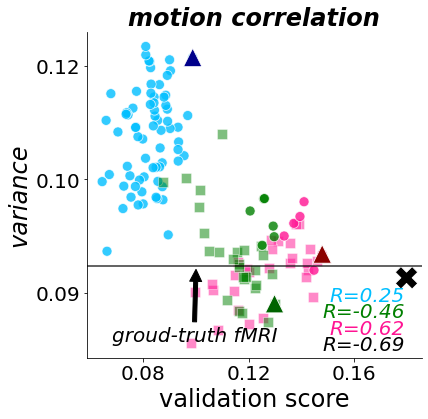

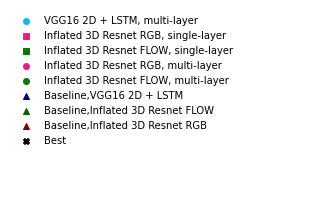

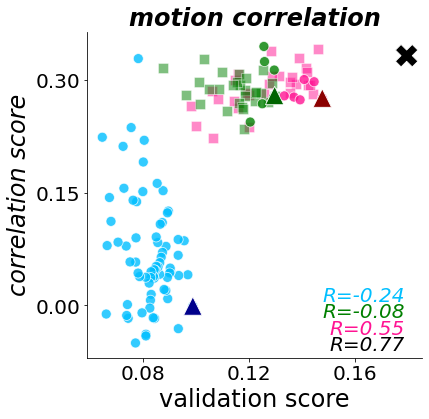

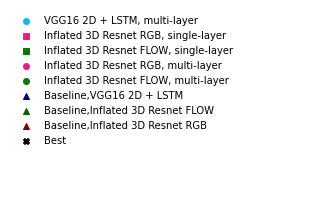

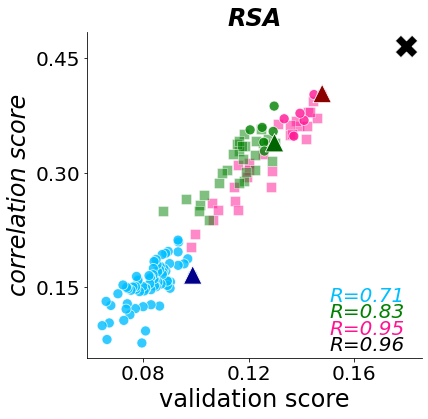

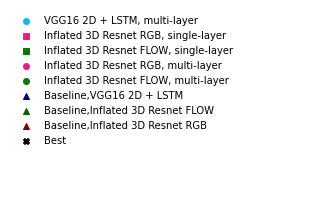

In [64]:
xs = res_df[x_key].values
for y_key in sorted(y_keys):
    ys = res_df[y_key].values
    
    # for x, y, label in zip(xs, ys, labels):
    #     plt.scatter(x, y, label=label)
    # plt.legend()
    # plt.show()
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    sns.scatterplot(x=x_key, y=y_key, 
                    hue='model_sch', 
                    style='model_sch',
                    size=res_df['size'].values.tolist(),
                    sizes=(100, 500),
                    palette=['deepskyblue', 'deeppink', 'green', 'deeppink', 'green', 'darkblue', 'darkgreen', 'darkred', 'black'],
                    markers=['o', 's', 's', 'o', 'o', '^', '^', '^', 'X'],
                    legend='auto',
                    alpha=res_df['alpha'].values.tolist(),
                    data=res_df)
    
    if y_key == 'motion_correlation_internal_variance':
        ax.axhline(y=gt_motion_correlation_internal_variance, color='black', linestyle='-', alpha=.8)
        ax.annotate('groud-truth fMRI', xy=(0.1, gt_motion_correlation_internal_variance), xytext=(0.068, gt_motion_correlation_internal_variance-0.01),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20, fontproperties=font)
    if y_key == 'face_index_internal_variance':
        ax.axhline(y=gt_face_index_internal_variance, color='black', linestyle='-', alpha=.8)
        ax.annotate('groud-truth fMRI', xy=(0.1, gt_face_index_internal_variance), xytext=(0.07, gt_face_index_internal_variance-0.004),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20, fontproperties=font)
    
    # title, xy label
    plt.xlabel('validation score', fontsize=24)
    ylabel = y_key.replace('_', ' ')
    if 'score' in ylabel:
        ylabel = 'correlation score'
    if 'internal variance' in ylabel:
        ylabel = 'variance'
    plt.ylabel(ylabel, fontsize=24, fontproperties=font, fontweight='normal')
    title = y_key.replace('_', ' ').replace(' score', '').replace(' internal variance', '')
    title = title.replace('rsa', 'RSA')
    plt.title(title, fontsize=24, fontweight='bold', fontproperties=font)
    
    formatter = matplotlib.ticker.FormatStrFormatter('%1.2f')
    locator = matplotlib.ticker.MaxNLocator(nbins=4)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    
    formatter = matplotlib.ticker.FormatStrFormatter('%1.2f')
    locator = matplotlib.ticker.MaxNLocator(nbins=4)
    ax.yaxis.set_major_locator(locator)
    ax.yaxis.set_major_formatter(formatter)
    
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    r = np.corrcoef(res_df[x_key], res_df[y_key])[0, 1]
    ax.text(0.95, 0.01, f'R={r:.2f}',
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            color='black', fontsize=20, fontproperties=font)
    
    for i, (color, model_schs) in enumerate(r_palette_group.items()):
        df = res_df
        # df['model_sch'] = df['model_sch'].apply(lambda x: [x])
        df = df[df['model_sch'].isin(model_schs)]
        r = np.corrcoef(df.val_score, df[y_key])[0, 1]
        ax.text(0.95, 0.01+(i+1)*0.05, f'R={r:.2f}',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color=color, fontsize=20, fontproperties=font)
    
    legend = ax.legend()
    # order = [0, 1, 2, 3, 4, 5, 7, 6, 8]
    legend_cols = 1
    # new_handels = np.asarray(legend.legendHandles[:-3])
    legend = ax.legend(*list(zip(*list(zip(*ax.get_legend_handles_labels()))[:-3])), 
                      bbox_to_anchor=(1.5,0.5), loc="center", 
                        bbox_transform=fig.transFigure, ncol=legend_cols,
                      fontsize=18,
                      frameon=False)
    for handle in legend.legendHandles:
        handle.set_sizes([200.0])
    
    # for handle in legend.legendHandles[-3:]:
    #     handle.set_sizes([0.0])
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # plt.show()
    # fig.savefig('test.png', bbox_extra_artists=[legend], bbox_inches='tight')
    ax.get_legend().remove()
    fig.savefig(f'figures/SCATTER {y_key}.pdf', bbox_inches='tight')
    
    
    # https://gist.github.com/rldotai/012dbb3294bb2599ff82e61e82356990
    
    # ---------------------------------------------------------------------
    # Create a separate figure for the legend
    # ---------------------------------------------------------------------
    # Bounding box for legend (in order to get proportions right)
    # Issuing a draw command seems necessary in order to ensure the layout
    # happens correctly; I was getting weird bounding boxes without it.
    fig.canvas.draw()
    # This gives pixel coordinates for the legend bbox (although perhaps 
    # if you are using a different renderer you might get something else).
    legend_bbox = legend.get_tightbbox(fig.canvas.get_renderer())
    # Convert pixel coordinates to inches
    legend_bbox = legend_bbox.transformed(fig.dpi_scale_trans.inverted())

    # Create teh separate figure, with appropriate width and height
    # Create a separate figure for the legend
    legend_fig, legend_ax = plt.subplots(figsize=(legend_bbox.width, legend_bbox.height))

    # Recreate the legend on the separate figure/axis
    legend_squared = legend_ax.legend(
        *list(zip(*list(zip(*ax.get_legend_handles_labels()))[:-3])), 
        # bbox_to_anchor=(0., 0., .1, .1),
        bbox_transform=legend_fig.transFigure,
        frameon=False,
        fancybox=None,
        shadow=False,
        ncol=legend_cols,
        mode='expand',
    )

    # Remove everything else from the legend's figure
    legend_ax.axis('off')
    # plt.margins(x=0, y=0)
    # bbox = legend_ax.get_tightbbox(legend_fig.canvas.get_renderer(), 
    #                  call_axes_locator = True,
    #                  bbox_extra_artists = None)
    # Save the legend as a separate figure
    legend_figpath = 'figures/SCATTER legend.pdf'
    # print(f"Saving to: {legend_figpath}")
    legend_fig.savefig(
        legend_figpath,
        bbox_inches='tight',
        # bbox_extra_artists=[legend_squared],
    )
    
    plt.show()
    # break